### Author: Allan Jeeboo 
### Preferred Name: Vyncent S. A. van der Wolvenhuizen 
### Affiliation: Data Science Student at TripleTen 
### Email: vanderwolvenhuizen.vyncent@gmail.com
### Date Started: 2025-03-21 
### Last Updated: 20215-03-26 15:32

# 1.0 Introduction
For this project, we'll be placing ourselves in a role where We need to predict whether a customer will Beta Bank soon. The scenario is that customers are leaving little by little and chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones. We have the data on clients’ past behavior and termination of contracts with the bank.

We will build a model with an F1 score of at least 0.59, then check the F1 for the test set. Additionally, we'll measure the AUC-ROC metric and compare it with the F1. 

First we'll be importing the data and have a quick overview. Then clean the data as needed and follow up with EDA. Afterward we'll examine the balance of classes and train the model without taking into account the imbalance, then briefly describe our findings. Following that, we'll improve the quality of the model, ensuring we use at least two approaches to fixing class imbalance. We'll use the training set to pick the best parameters, then train different models on training and validation sets, find the best one, and briefly describe our findings. To finish, we'll perform the final testing.

### 1.1 Data Import & Overview
First let's import the necessary libraries and modules for this project, then import the data. To get an overview of what we're working with, let's look at the first five rows of the data, print the shape, and print the data types. 

In [76]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, PrecisionRecallDisplay,precision_score, r2_score, recall_score, roc_curve, roc_auc_score  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.utils import shuffle
import seaborn as sns

df = pd.read_csv('Churn.csv') 
display(df.head()) 
print(f'rows, columns:\n{df.shape}\n')
print(f'Data types:\n{df.dtypes}')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


rows, columns:
(10000, 14)

Data types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


# 1.2 Data Description
Here is a description of all of the columns: 

Features:   
- RowNumber — data string index  
- CustomerId — unique customer identifier  
- Surname — surname  
- CreditScore — credit score  
- Geography — country of residence  
- Gender — gender  
- Age — age  
- Tenure — period of maturation for a customer’s fixed deposit (years)  
- Balance — account balance  
- NumOfProducts — number of banking products used by the customer  
- HasCrCard — customer has a credit card  
- IsActiveMember — customer’s activeness  
- EstimatedSalary — estimated salary

Target:  
- Exited — сustomer has left

# 2.0 Preprocessing & EDA
Now let's clean the data. Right off the bat I see that all of the column names are capitalized and multi-word column names are crushed together. Let's fix this so it adheres to the PEP8 Style Guide for Python Code. The next issue I see is the RowNumber column. Considering dataframes already have explicit indices, is this column really necessary?

### 2.1 Preprocessing

In [77]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'creditscore': 'credit_score', 
                        'numofproducts': 'num_of_products', 
                        'hascrcard': 'has_credit_card', 
                        'isactivemember': 'is_active_member', 
                        'estimatedsalary': 'estimated_salary'}) 
df = df.reset_index(drop=True)
display(df.head())

,rownumber,customerid,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [78]:
df = df.drop(['rownumber', 'surname'], axis= 1)

Let's check for NaNs and duplicates.

In [79]:
print(f'NaNs:\n{df.isna().sum()}\n')
print(f'NaNs percentage:\n{df.isna().sum()/df.shape[0]*100}\n')

NaNs:
customerid            0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_credit_card       0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

NaNs percentage:
customerid          0.00
credit_score        0.00
geography           0.00
gender              0.00
age                 0.00
tenure              9.09
balance             0.00
num_of_products     0.00
has_credit_card     0.00
is_active_member    0.00
estimated_salary    0.00
exited              0.00
dtype: float64



There are 909 NaNs in df['tenure'], which is 9.09% of the column's data. Perhaps let's use interpolation to fix this.

In [80]:
#df.tenure = df.tenure.fillna(df.tenure.median())
df.tenure = df.tenure.interpolate(method='linear', limit_direction='both')
print(f'NaNs:\n{df.isna().sum()}\n')

NaNs:
customerid          0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_credit_card     0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64



In [81]:
df.dtypes

customerid            int64
credit_score          int64
geography            object
gender               object
age                   int64
tenure              float64
balance             float64
num_of_products       int64
has_credit_card       int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [82]:
df.tenure = df.tenure.astype('int64')

Now that we've fixed that, let's check for duplicates.

In [83]:
df.duplicated().sum()

np.int64(0)

In [84]:
df = pd.get_dummies(df, drop_first=True)
df = df.rename(columns={'geography_Germany': 'germany', 
                        'geography_Spain': 'spain', 
                        'gender_Male': 'male'})
df.head()

,customerid,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,germany,spain,male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


No duplicates, beautiful. We can now move on to the next step: EDA!

### 2.2 EDA Start


Since this project is centered on customers leaving, let's see how many have left. First let's look at our data again and then summate how many customers have left (df.exited == 1) and divide it by the total number of customers (df.shape), then multiply by 100 to obtain the percentage.

In [85]:
df.head()

,customerid,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,germany,spain,male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [86]:
customer = df[df.exited == 0] 
former_customer = df[df.exited == 1]

print('Customers:')
display(customer.head())
print('Former Customers:')
display(former_customer.head())

Customers:


,customerid,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,germany,spain,male
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False
6,15592531,822,50,7,0.00,2,1,1,10062.80,0,False,False,True
8,15792365,501,44,4,142051.07,2,0,1,74940.50,0,False,False,True


Former Customers:


,customerid,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,germany,spain,male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
5,15574012,645,44,8,113755.78,2,1,0,149756.71,1,False,True,True
7,15656148,376,29,4,115046.74,4,1,0,119346.88,1,True,False,False
16,15737452,653,58,1,132602.88,1,1,0,5097.67,1,True,False,True


In [87]:
exited_customers = (df.exited == 1).sum()/df.shape[0]*100
print(f'Exited customers percentage: {exited_customers}%')

Exited customers percentage: 20.369999999999997%


Text(0, 0.5, 'Count')

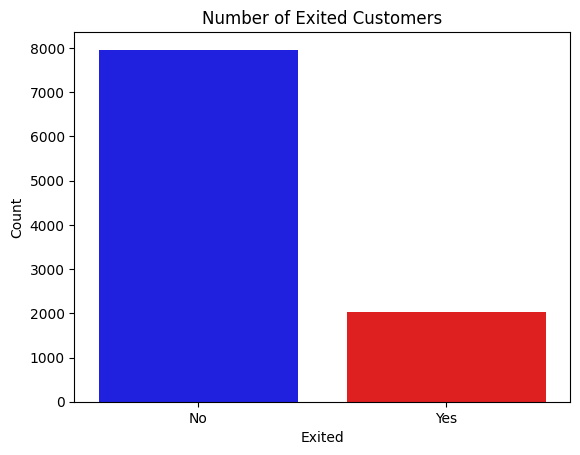

In [88]:
# Create the counts DataFrame
counts = df['exited'].value_counts().reset_index()
counts.columns = ['exited', 'count']
counts['exited'] = counts['exited'].replace({0: 'No', 1: 'Yes'})

# Plot the counts
sns.barplot(x= 'exited', 
            y= 'count', 
            data= counts, 
            palette= {'No': 'blue', 'Yes': 'red'}, 
            hue= 'exited')

plt.title('Number of Exited Customers') 
plt.xlabel('Exited')
plt.ylabel('Count')

20.37% of customers have left.

### 2.3 Credit Score

In [89]:
customer_credit_score_describe = customer.credit_score.describe()
former_customer_credit_score_describe = former_customer.credit_score.describe()

print("Description of Customers' Credit Score:")
print(customer_credit_score_describe, "\n")
print("Description of Former Customers' Credit Score:")
print(former_customer_credit_score_describe)

Description of Customers' Credit Score:
count    7963.000000
mean      651.853196
std        95.653837
min       405.000000
25%       585.000000
50%       653.000000
75%       718.000000
max       850.000000
Name: credit_score, dtype: float64 

Description of Former Customers' Credit Score:
count    2037.000000
mean      645.351497
std       100.321503
min       350.000000
25%       578.000000
50%       646.000000
75%       716.000000
max       850.000000
Name: credit_score, dtype: float64


In [90]:
df.exited.corr(df.credit_score)

np.float64(-0.02709353975465779)

<Axes: xlabel='credit_score', ylabel='Count'>

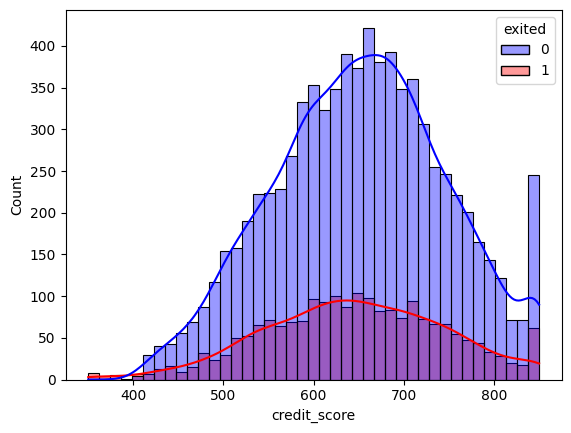

In [91]:
sns.histplot(data=df, 
             x= 'credit_score', 
             palette= {0: 'blue', 1: 'red'},
             hue= 'exited', 
             kde= True, 
             alpha= 0.4)

The description and graph do not seem to suggest a correlation between credit score and whether or not a customer stays.

### 2.4 Geography

In [92]:
french = (customer.germany == 0) & (customer.spain == 0)
german = (customer.germany == 1) & (customer.spain == 0)
spanish = (customer.spain == 1) & (customer.germany == 0)

french_customers = french == 1
former_french_customers = french == 0 

german_customers = german == 1 
former_german_customers = german == 0 

spanish_customers = spanish == 1 
former_spanish_customers = spanish_customers == 0 
former_french_customers.head()


1     True
3    False
4     True
6    False
8    False
dtype: bool

In [93]:
france_exit_percentage = (former_french_customers == 1).sum() / french.shape[0]

print(f'Percentage of customers who have exited in France: {france_exit_percentage}') 
#print(f'Percentage of customers who have exited in Germany: {germany_exited_percentage:.2f}%')
#print(f'Percentage of customers who have exited in Spain: {spain_exited_percentage:.2f}%')


Percentage of customers who have exited in France: 0.47205826949642093


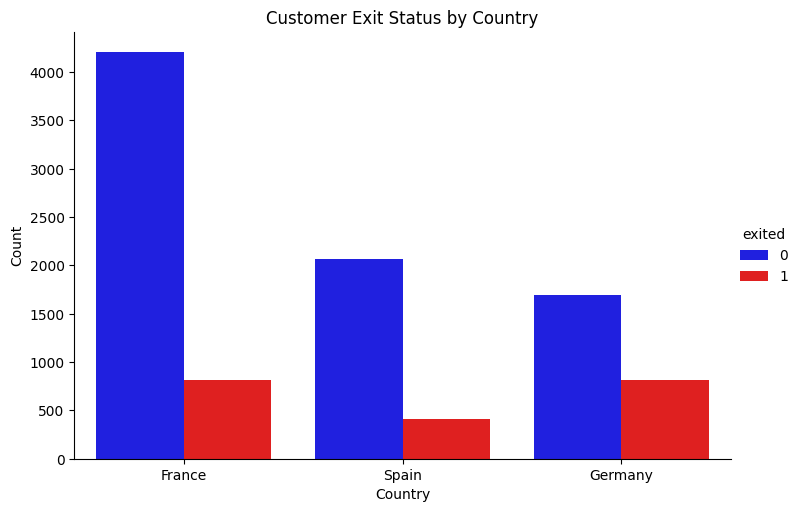

In [94]:
# Create the geo_counts DataFrame
geo_counts = df.groupby(['germany', 'spain', 'exited']).size().reset_index(name='count')

# Replace boolean values with country names for better visualization
geo_counts['country'] = geo_counts.apply(
    lambda row: 'Germany' if row['germany'] else ('Spain' if row['spain'] else 'France'), axis=1
)

# Plot the data using seaborn's catplot
plot = sns.catplot(
    data=geo_counts,
    x='country',
    y='count',
    hue='exited',
    kind='bar',
    palette={0: 'blue', 1: 'red'},
    height=5,
    aspect=1.5
)

plt.title('Customer Exit Status by Country')
plt.xlabel('Country')
plt.ylabel('Count')

plt.show()

In section 2.2 we established that an overall average of 20.37% of customers left Beta Bank. When we look at the averages by country, that changes. In France and Spain, 16.15% and 16.67% of customers left, but in Germany that figure is 32.44%. That's about twice as much as France and Spain, plus tnat's 1/3 of all German customers. Why is the exit rate so high in Germany?

### 2.5 Gender

In [95]:
customer_gender_count = customer.gender.value_counts()

print(f'Gender Count:\n{customer_gender_count} \n')
print(f'Gender Count (Percentage):\n{customer_gender_count/customer.shape[0]*100}')

AttributeError: 'DataFrame' object has no attribute 'gender'

In [ ]:
former_customer_gender_count = former_customer.gender.value_counts()

print(f'Former Customer Gender Count:\n{former_customer_gender_count} \n')
print(f'Former Customer Gender Count (Percentage):\n{former_customer_gender_count/former_customer.shape[0]*100} \n')

Former Customer Gender Count:
gender
Female    1139
Male       898
Name: count, dtype: int64 

Former Customer Gender Count (Percentage):
gender
Female    55.915562
Male      44.084438
Name: count, dtype: float64 



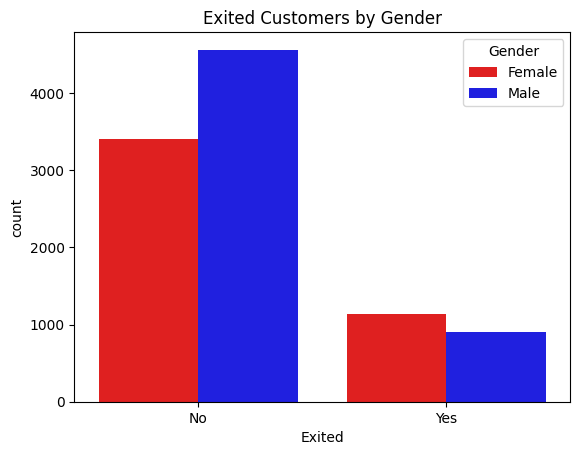

In [ ]:
# Calculate counts for each combination of 'exited' and 'gender'
gender_counts = df.groupby(['exited', 'gender']).size().reset_index(name='count')

# Plot the counts
sns.barplot(data= gender_counts, 
            x= 'exited', 
            y= 'count',  
            hue= 'gender', 
            dodge= True, 
            palette= {'Male': 'blue', 'Female': 'red'})

plt.title('Exited Customers by Gender')
plt.xlabel('Exited')
plt.xticks(ticks= [0, 1], labels= ['No', 'Yes'])
plt.legend(title= 'Gender')

While the barplot seems to indicate there are differences, the raw percentages between the two suggests that gender does not affect whether or not a customer leaves.  

Customers by gender:  
- Male: 57.25%  
- Female: 42.75%

Former Customers by gender:  
- Female: 55.92%  
- Male: 44.08%

### 2.6 Age

In [ ]:
customer_age_describe = customer.age.describe()
former_customer_age_describe = former_customer.age.describe()

print("Description of Customers' Age:")
print(customer_age_describe)
print()
print("Description of Former Customers' Age:")
print(former_customer_age_describe)

Description of Customers' Age:
count    7963.000000
mean       37.408389
std        10.125363
min        18.000000
25%        31.000000
50%        36.000000
75%        41.000000
max        92.000000
Name: age, dtype: float64

Description of Former Customers' Age:
count    2037.000000
mean       44.837997
std         9.761562
min        18.000000
25%        38.000000
50%        45.000000
75%        51.000000
max        84.000000
Name: age, dtype: float64


In [ ]:
df.exited.corr(df.age)

np.float64(0.2853230378350683)

Text(0.5, 0, 'Age')

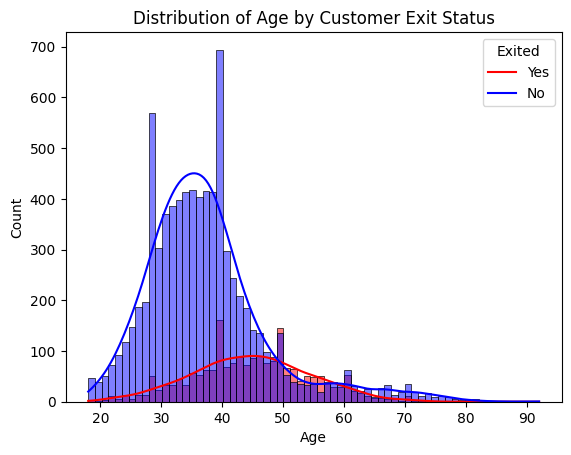

In [ ]:
ax = sns.histplot(data= df, 
                  x= 'age', 
                  palette= {0: 'blue', 1: 'red'}, 
                  hue= 'exited', 
                  hue_order= [0, 1], 
                  kde= True)
legend = ax.legend(labels= ['Yes', 'No'])
legend.set_title('Exited')

plt.title('Distribution of Age by Customer Exit Status')
plt.xlabel('Age')

The age desciption and histogram seem to indicate that former customers tend to be older than those who are still customers.

### 2.7 Tenure

In [ ]:
customer_tenure_describe = customer.tenure.describe()
former_customer_tenure_describe = former_customer.tenure.describe()

print(f'Customer tenure:\n{customer_tenure_describe}\n')
print(f'Former Customer tenure:\n{former_customer_tenure_describe}\n')

Customer tenure:
count    7963.000000
mean        4.998744
std         2.817081
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Former Customer tenure:
count    2037.000000
mean        4.879234
std         2.878882
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64



In [ ]:
df.exited.corr(df.tenure)

np.float64(-0.017008531887356036)

Text(1.8209861111111127, 0.5, 'Count')

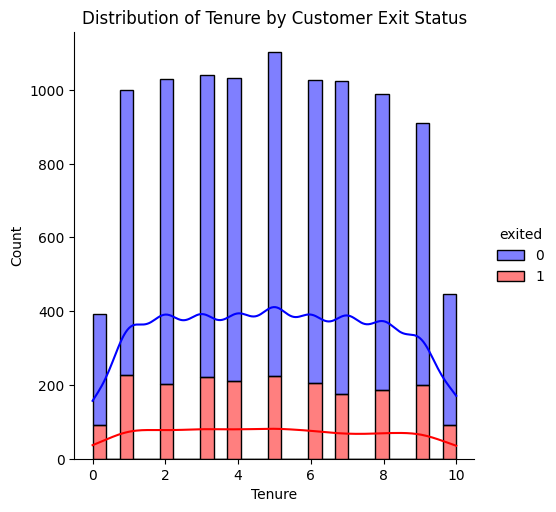

In [ ]:
sns.displot(data=df, 
            x= 'tenure', 
            hue= 'exited', 
            palette= {0: 'blue', 1: 'red'}, 
            multiple= 'stack', 
            kde= True) 

plt.title('Distribution of Tenure by Customer Exit Status')
plt.xlabel('Tenure')
plt.ylabel('Count')

It doesn't seem like tenure has an impact on whether a customer exits.

### 2.8 Account Balance

In [ ]:
print("Description of Customers' Balances:")
print(customer.balance.describe())
print()
print("Description of Former Customers' Balances:")
print(former_customer.balance.describe())

Description of Customers' Balances:
count      7963.000000
mean      72745.296779
std       62848.040701
min           0.000000
25%           0.000000
50%       92072.680000
75%      126410.280000
max      221532.800000
Name: balance, dtype: float64

Description of Former Customers' Balances:
count      2037.000000
mean      91108.539337
std       58360.794816
min           0.000000
25%       38340.020000
50%      109349.290000
75%      131433.330000
max      250898.090000
Name: balance, dtype: float64


In [ ]:
df.exited.corr(df.balance)

np.float64(0.11853276877163371)

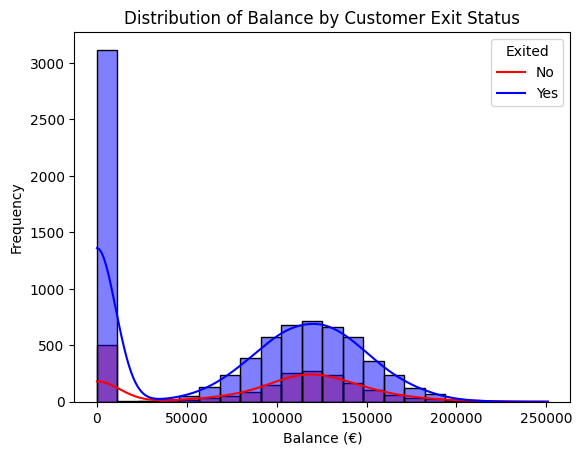

In [ ]:
sns.histplot(data=df, 
             x='balance', 
             hue='exited', 
             palette={0: 'blue', 1: 'red'}, 
             kde=True)

plt.title('Distribution of Balance by Customer Exit Status')
plt.xlabel('Balance (€)')
plt.ylabel('Frequency') 
plt.legend(title='Exited', labels=['No', 'Yes'])

### 2.9 Number of Products

In [ ]:
print("Description of the Number of Products that Customers Use:")
print(customer.num_of_products.describe())
print()
print("Description of the Number of Products that Former Customers Used:") 
print(former_customer.num_of_products.describe())

Description of the Number of Products that Customers Use:
count    7963.000000
mean        1.544267
std         0.509536
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: num_of_products, dtype: float64

Description of the Number of Products that Former Customers Used:
count    2037.000000
mean        1.475209
std         0.801521
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: num_of_products, dtype: float64


In [ ]:
df.exited.corr(df.num_of_products)

np.float64(-0.04781986494944054)

<Axes: xlabel='num_of_products', ylabel='Count'>

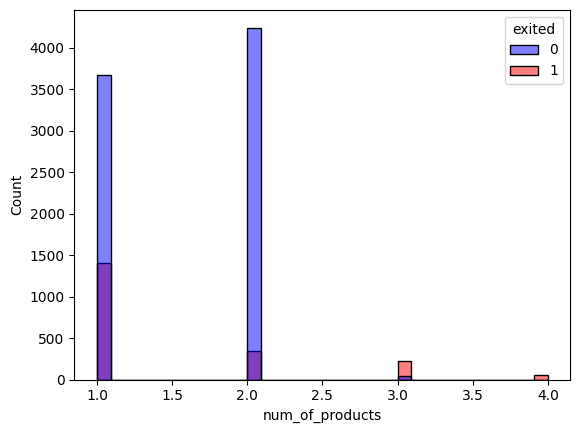

In [ ]:
sns.histplot(data= df, 
            x= 'num_of_products', 
            hue= 'exited', 
            palette= {0: 'blue', 1: 'red'})

### 2.10 Credit Card

In [ ]:
print('Customers who have credit cards:')
print(customer.has_credit_card.value_counts(),
      '\n',
      customer.has_credit_card.value_counts()[0] / customer.shape[0] * 100,'% do not have credit cards')
print()
print('Former customers who have credit cards:')
print(former_customer.has_credit_card.value_counts(),
      '\n',
      former_customer.has_credit_card.value_counts()[0] / former_customer.shape[0] * 100,'% do not have credit cards')

Customers who have credit cards:
has_credit_card
1    5631
0    2332
Name: count, dtype: int64 
 29.285445183975888 % do not have credit cards

Former customers who have credit cards:
has_credit_card
1    1424
0     613
Name: count, dtype: int64 
 30.09327442317133 % do not have credit cards


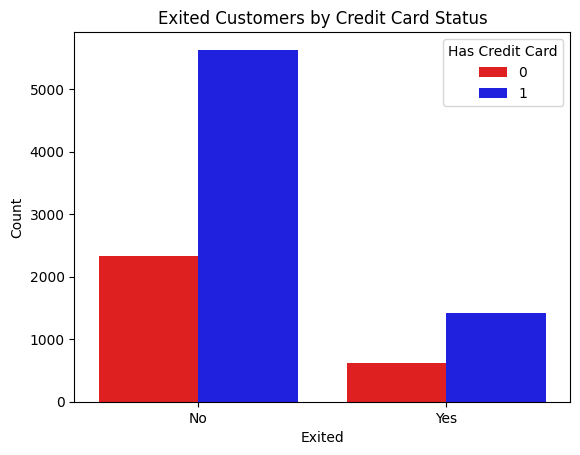

In [ ]:
df_has_credit_card = df.groupby(['exited', 'has_credit_card']).size().reset_index(name='count') 

sns.barplot(data= df_has_credit_card, 
            x= 'exited', 
            y= 'count', 
            hue= 'has_credit_card', 
            palette= {1: 'blue', 0: 'red'})

plt.title('Exited Customers by Credit Card Status')
plt.xlabel('Exited') 
plt.ylabel('Count') 
plt.xticks(ticks= [0, 1], labels= ['No', 'Yes']) 
plt.legend(title='Has Credit Card')

The ratio of individuals who don't have credit cards between customers and former customers is nearly identical, which suggests that having a credit card does not affect whether or not a customer leaves.

### 2.11 Active Members

In [ ]:
print('Customers who are active members:')
print(customer.is_active_member.value_counts(),
      '\n',
      customer.is_active_member.value_counts()[0] / customer.shape[0] * 100,'% are not active members')
print()
print('Former customers who are active members:')
print(former_customer.is_active_member.value_counts(),
      '\n',
      former_customer.is_active_member.value_counts()[0] / former_customer.shape[0] * 100,'% are not active members')

Customers who are active members:
is_active_member
1    4416
0    3547
Name: count, dtype: int64 
 44.543513751098835 % are not active members

Former customers who are active members:
is_active_member
0    1302
1     735
Name: count, dtype: int64 
 63.91752577319587 % are not active members


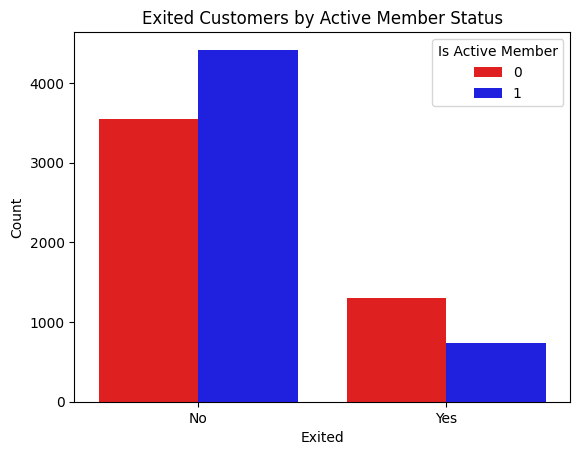

In [ ]:
df_is_active = df.groupby(['exited', 'is_active_member']).size().reset_index(name='count') 

sns.barplot(data= df_is_active, 
            x= 'exited', 
            y= 'count', 
            hue= 'is_active_member', 
            palette= {1: 'blue', 0: 'red'})

plt.title('Exited Customers by Active Member Status')
plt.xlabel('Exited') 
plt.ylabel('Count') 
plt.xticks(ticks= [0, 1], labels= ['No', 'Yes']) 
plt.legend(title='Is Active Member')

In [ ]:
df.head()

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 2.12 Estimated Salary 

In [ ]:
print('Description of customers\' estimated salaries:')
print(customer.estimated_salary.describe(), '\n')
print('Description of former customers\' estimated salaries:')
print(former_customer.estimated_salary.describe())

Description of customers' estimated salaries:
count      7963.000000
mean      99738.391772
std       57405.586966
min          90.070000
25%       50783.490000
50%       99645.040000
75%      148609.955000
max      199992.480000
Name: estimated_salary, dtype: float64 

Description of former customers' estimated salaries:
count      2037.000000
mean     101465.677531
std       57912.418071
min          11.580000
25%       51907.720000
50%      102460.840000
75%      152422.910000
max      199808.100000
Name: estimated_salary, dtype: float64


In [ ]:
df.exited.corr(df.estimated_salary)

np.float64(0.01209686102684467)

Text(0, 0.5, 'Frequency')

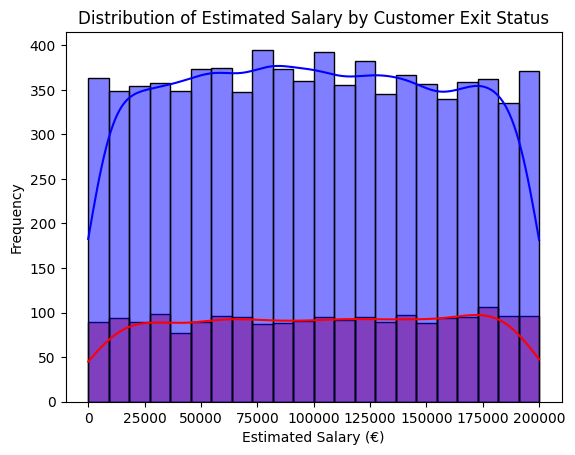

In [ ]:
sns.histplot(data= df, 
             x= 'estimated_salary', 
             hue= 'exited', 
             palette= {0: 'blue', 1: 'red'}, 
             kde= True, 
             legend= False, 
             alpha= 0.5)

plt.title('Distribution of Estimated Salary by Customer Exit Status')
plt.xlabel('Estimated Salary (€)') 
plt.ylabel('Frequency')

There seems to be a relatively even dispersion of estimated salaries between both current and former customers. Nothing suggests that this feature has an impact on customer exit status.

### 2.13 EDA Conclusion 
Overall, country, age, and customer activity seem to impact whether or not customers leave. Country seems to have the strongest influence - specifically Germany where the exit rate is twice as high as the other two countries in the data (France and Spain).

# 3.0 Model 
Recall in subsection 2.2, we found that 20.37% of customers have left. As this constitutes the lesser of the two classes, this is our minority group. First let's train a model without taking into account class imbalance and briefly describe what we find from that. After that, we'll improve the quality of the model by using two approaches to addressing class imbalance. Based on our findings, we'll choose the better of the two and then perform a final testing.

### 3.1 Balance of Classes

In [ ]:
features = df.drop('exited', axis= 1)
target= df.exited
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size= 0.2, 
                                                                              random_state= 12345) 

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

In [ ]:
model = LogisticRegression(random_state=12345, 
                           class_weight= 
                           'balanced', 
                           solver='liblinear')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, 
                          predicted_valid) 

print(f'Accuracy: {accuracy}')
print('F1:', f1_score(target_valid, predicted_valid))

Accuracy: 0.7155
F1: 0.514919011082694


In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.5
)

model = LogisticRegression(solver= 'liblinear', random_state= 12345) 
model.fit(features_downsampled, target_downsampled) 
predicted_valid = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_valid)
 # < write code here >

print(f'Accuracy: {accuracy}')
print('F1:', f1_score(target_valid, predicted_valid))

Accuracy: 0.7865
F1: 0.004662004662004662


In [ ]:
matrix = confusion_matrix(target_valid, predicted_valid)
matrix

array([[1336,  237],
       [ 231,  196]])

In [ ]:
recall = recall_score(target_valid, predicted_valid)
print(f'Recall: {recall}')

Recall: 0.7072599531615925


In [ ]:
precision = precision_score(target_valid, predicted_valid)
print(f'Precision: {precision}')

Precision: 0.40482573726541554


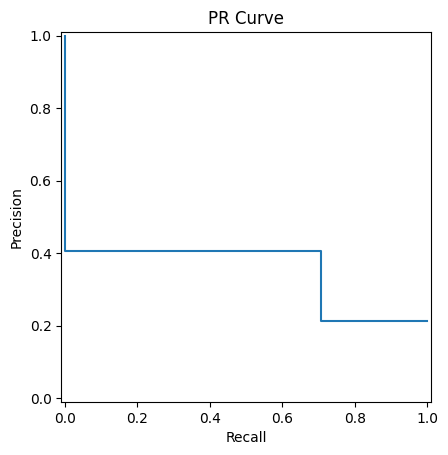

In [96]:
precision, recall, _ = precision_recall_curve(target_valid, predicted_valid)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.title('PR Curve')
plt.show()

In [ ]:
f1 = f1_score(target_valid, predicted_valid)
print(f'F1 score: {f1}')

F1 score: 0.514919011082694


In [ ]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC score: {auc_roc}')

AUC-ROC score: 0.7711811288562407


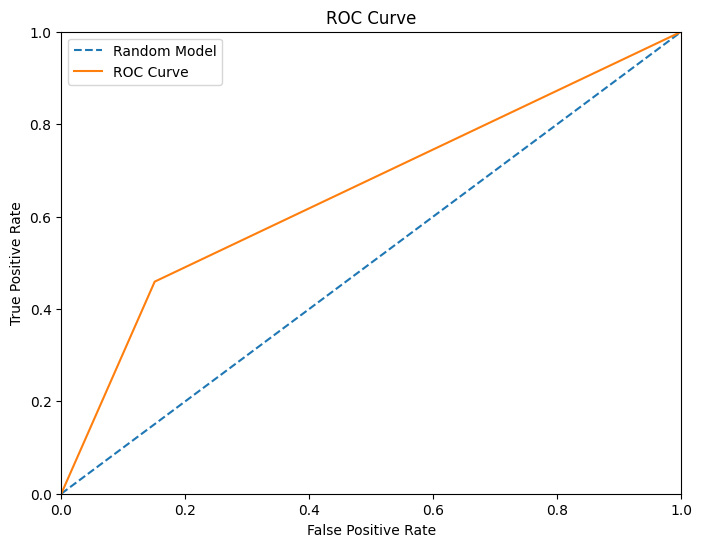

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

np.float64(0.6541744395693726)